In [16]:
import os
import json
from web3 import Web3, HTTPProvider

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from utils.subgraph_utils.convex_community import get_curve_fees

In [2]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
web3 = Web3(HTTPProvider(f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}"))

In [3]:
admin = "0xeCb456EA5365865EbAb8a2661B0c503410e9B347"
pool_addr = "0x5a6A4D54456819380173272A5E8E9B9904BdF41B"
lp_token_addr = "0x5a6A4D54456819380173272A5E8E9B9904BdF41B"
threecrv_addr = "0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490"
mim_addr = "0x99D8a9C45b2ecA8864373A26D1459e3Dff1e17F3"

In [11]:
pool_addr.lower()

'0x5a6a4d54456819380173272a5e8e9b9904bdf41b'

Need individual coin addrs:

In [4]:
with open("./3crv.json", 'r') as f:
    abi = json.load(f)
threecrv = web3.eth.contract(address=threecrv_addr, abi=abi)

with open("./mim.json", 'r') as f:
    abi = json.load(f)
mim = web3.eth.contract(address=mim_addr, abi=abi)

In [22]:
subgraph_tripool_fees = get_curve_fees(pool_token_addr=lp_token_addr)
blocks = list([int(i) for i in subgraph_tripool_fees.block.values])
subgraph_block_ranges = list(zip(blocks, blocks[1:]))
subgraph_tripool_fees.index = subgraph_tripool_fees.block

In [27]:
fees_for_range = []
for (block_start, block_end) in subgraph_block_ranges:

    print(f"Chain checkoooor-ing blocks: {block_start}:{block_end}")

    mim_transfer_filter = mim.events.Transfer.createFilter(
        fromBlock=block_start,
        toBlock=block_end
    )
    all_transfers = mim_transfer_filter.get_all_entries()
    mim_fees = 0
    for transfer in all_transfers:

        to_address = transfer['args']['_to']
        from_address = transfer['args']['_from']
        value = transfer['args']['_value']
        block = transfer['blockNumber']

        if (
                from_address == pool_addr and
                to_address == admin
        ):
            mim_fees += value*1e-18
            print(transfer['transactionHash'].hex())
            raise

    threecrv_transfer_filter = threecrv.events.Transfer.createFilter(
        fromBlock=block_start,
        toBlock=block_end
    )
    all_transfers = threecrv_transfer_filter.get_all_entries()
    threecrv_fees = 0
    for transfer in all_transfers:

        to_address = transfer['args']['_to']
        from_address = transfer['args']['_from']
        value = transfer['args']['_value']
        block = transfer['blockNumber']

        if (
                from_address == pool_addr and
                to_address == admin
        ):
            threecrv_fees += value*1e-18
            print(transfer['transactionHash'].hex())
            raise

    dict_fees = {
        'block_start': block_start,
        'block_end': block_end,
        'mim_fees': mim_fees,
        'threecrv_fees': threecrv_fees
    }
    fees_for_range.append(dict_fees)

df_fees = pd.DataFrame(fees_for_range)
df_fees

Chain checkoooor-ing blocks: 13007147:13052446
Chain checkoooor-ing blocks: 13052446:13097719
Chain checkoooor-ing blocks: 13097719:13142950
Chain checkoooor-ing blocks: 13142950:13189474
Chain checkoooor-ing blocks: 13189474:13233504


KeyboardInterrupt: 

In [24]:
transfer

AttributeDict({'args': AttributeDict({'_from': '0xA79828DF1850E8a3A3064576f380D90aECDD3359',
  '_to': '0x5a6A4D54456819380173272A5E8E9B9904BdF41B',
  '_value': 87132695657344429131504}),
 'event': 'Transfer',
 'logIndex': 306,
 'transactionIndex': 315,
 'transactionHash': HexBytes('0xa256deccaf4887dac401f089a8693323307dfc4da17fa6d94980db938e213fe3'),
 'address': '0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490',
 'blockHash': HexBytes('0xb6b219010adeb786db55cf530666a22e48477194c47b1afdabdda5fa45a83f33'),
 'blockNumber': 13592431})

In [19]:
df_fees['total_fees'] = df_fees.mim_fees + df_fees.threecrv_fees
df_fees.index = df_fees.block_end
df_fees

,block_start,block_end,mim_fees,threecrv_fees,total_fees
block_end,,,,,
13052446,13007147,13052446,0.000000,30686.849024,30686.849024
13097719,13052446,13097719,0.000000,21871.493914,21871.493914
13142950,13097719,13142950,0.000000,15312.747985,15312.747985
13189474,13142950,13189474,0.000000,12821.426944,12821.426944
13233504,13189474,13233504,0.000000,14412.784917,14412.784917
13279324,13233504,13279324,0.000000,9528.335792,9528.335792
13324114,13279324,13324114,0.000000,13613.168479,13613.168479
13368595,13324114,13368595,0.000000,8788.121851,8788.121851
13413314,13368595,13413314,0.000000,14670.468288,14670.468288


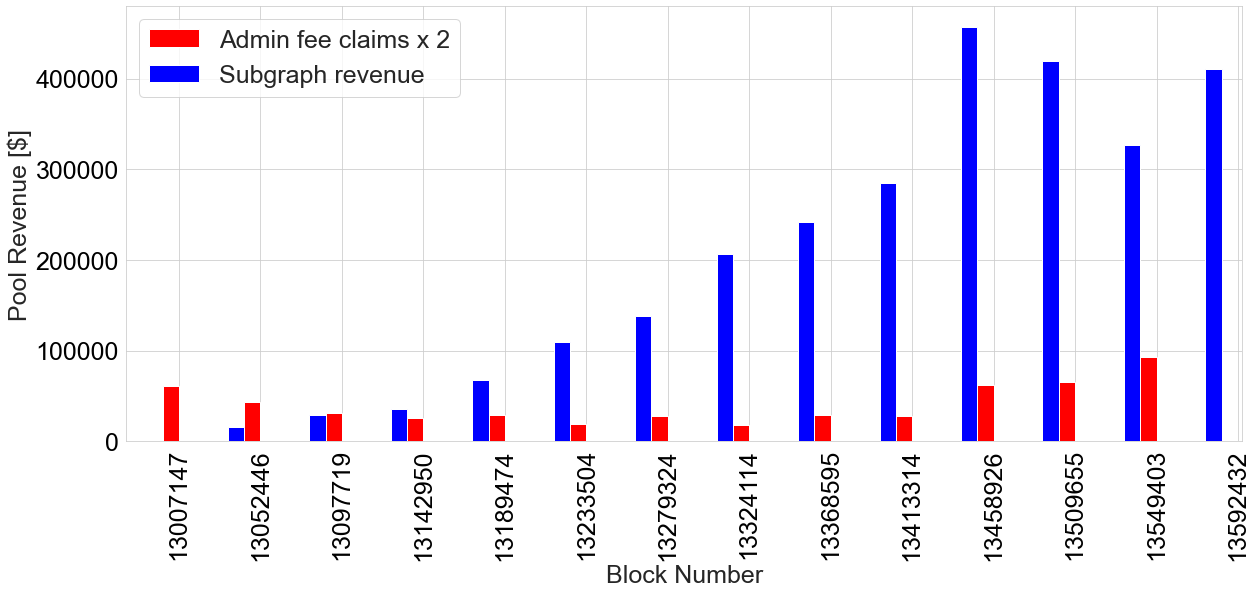

In [23]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

(df_fees['total_fees']*2).plot(
    ax=ax,
    color='red',
    kind='bar',
    label='Admin fee claims x 2',
    width=0.2,
    position=1,
)
subgraph_tripool_fees['fees'].plot(
    ax=ax,
    color='blue',
    kind='bar',
    label='Subgraph revenue',
    width=0.2,
    position=2,
)

ax.set_ylabel("Pool Revenue [$]", fontsize=25)
ax.set_xlabel("Block Number", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.legend(fontsize=25);